# Store Item Demand Forecasting with Baseline LightGBM Regressor

## Import required libraries

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import time

import warnings
warnings.filterwarnings("ignore")

import lightgbm as lgb
from sklearn.metrics import mean_squared_error, r2_score
import pickle

## Read datasets

In [4]:
# google colab
from google.colab import drive
drive.mount('/content/drive')

train_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ml project/train.csv', parse_dates = ['date'])
test_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ml project/test.csv', parse_dates = ['date'])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# # jupyter
# train_data = pd.read_csv('train.csv', parse_dates = ['date'])
# test_data = pd.read_csv('test.csv', parse_dates = ['date'])

In [6]:
train_data.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [7]:
test_data.head()

,id,date,store,item
0,0,2018-01-01,1,1
1,1,2018-01-02,1,1
2,2,2018-01-03,1,1
3,3,2018-01-04,1,1
4,4,2018-01-05,1,1


In [8]:
data = pd.concat([train_data, test_data],sort= False)

data

,date,store,item,sales,id
0,2013-01-01,1,1,13.0,NaN
1,2013-01-02,1,1,11.0,NaN
2,2013-01-03,1,1,14.0,NaN
3,2013-01-04,1,1,13.0,NaN
4,2013-01-05,1,1,10.0,NaN
...,...,...,...,...,...
44995,2018-03-27,10,50,NaN,44995.0
44996,2018-03-28,10,50,NaN,44996.0
44997,2018-03-29,10,50,NaN,44997.0
44998,2018-03-30,10,50,NaN,44998.0


## Data preprocessing

### Feature engineering

#### Datetime features

In [9]:
def create_date_time_features(df):
    df = df.copy()

    df['day_of_week'] = df.date.dt.dayofweek
    df['quarter'] = df.date.dt.quarter
    df['month'] = df.date.dt.month
    df['week_of_year'] = df.date.dt.isocalendar().week.astype("int64")

    return df

In [10]:
df1 = create_date_time_features(data)

df1.head()

,date,store,item,sales,id,day_of_week,quarter,month,week_of_year
0,2013-01-01,1,1,13.0,NaN,1,1,1,1
1,2013-01-02,1,1,11.0,NaN,2,1,1,1
2,2013-01-03,1,1,14.0,NaN,3,1,1,1
3,2013-01-04,1,1,13.0,NaN,4,1,1,1
4,2013-01-05,1,1,10.0,NaN,5,1,1,1


#### Lag features

In [11]:
def lag_features(df, lags):
    for lag in lags:
        df['sales_lag_' + str(lag)] = df.groupby(["store", "item"])['sales'].transform(lambda x: x.shift(lag))
        
    return df

In [12]:
df1 = lag_features(df1, [91, 98, 105, 112, 119, 126, 182, 364, 546, 728])

df1.head()

,date,store,item,sales,id,day_of_week,quarter,month,week_of_year,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728
0,2013-01-01,1,1,13.0,NaN,1,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-02,1,1,11.0,NaN,2,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-03,1,1,14.0,NaN,3,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-01-04,1,1,13.0,NaN,4,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-05,1,1,10.0,NaN,5,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Rolling mean features

In [13]:
def roll_mean_features(df, windows):
    for window in windows:
        df['sales_roll_mean_' + str(window)] = df.groupby(["store", "item"])['sales']. \
                                             transform(lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean())
                                             
    return df

In [14]:
df1 = roll_mean_features(df1, [365, 546])

df1.head()

,date,store,item,sales,id,day_of_week,quarter,month,week_of_year,sales_lag_91,...,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,sales_roll_mean_365,sales_roll_mean_546
0,2013-01-01,1,1,13.0,NaN,1,1,1,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-02,1,1,11.0,NaN,2,1,1,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-03,1,1,14.0,NaN,3,1,1,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-01-04,1,1,13.0,NaN,4,1,1,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-05,1,1,10.0,NaN,5,1,1,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Exponentially weighted mean features

In [15]:
def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby(["store", "item"])['sales'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
                
    return dataframe

In [16]:
alphas = [0.95, 0.9, 0.8, 0.7, 0.5]
lags   = [91, 98, 105, 112, 180, 270, 365, 546, 728]

In [17]:
df1 = ewm_features(df1, alphas, lags)

df1.head()

,date,store,item,sales,id,day_of_week,quarter,month,week_of_year,sales_lag_91,...,sales_ewm_alpha_07_lag_728,sales_ewm_alpha_05_lag_91,sales_ewm_alpha_05_lag_98,sales_ewm_alpha_05_lag_105,sales_ewm_alpha_05_lag_112,sales_ewm_alpha_05_lag_180,sales_ewm_alpha_05_lag_270,sales_ewm_alpha_05_lag_365,sales_ewm_alpha_05_lag_546,sales_ewm_alpha_05_lag_728
0,2013-01-01,1,1,13.0,NaN,1,1,1,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-02,1,1,11.0,NaN,2,1,1,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-03,1,1,14.0,NaN,3,1,1,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-01-04,1,1,13.0,NaN,4,1,1,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-05,1,1,10.0,NaN,5,1,1,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Summary

In [18]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 958000 entries, 0 to 44999
Data columns (total 66 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   date                         958000 non-null  datetime64[ns]
 1   store                        958000 non-null  int64         
 2   item                         958000 non-null  int64         
 3   sales                        913000 non-null  float64       
 4   id                           45000 non-null   float64       
 5   day_of_week                  958000 non-null  int64         
 6   quarter                      958000 non-null  int64         
 7   month                        958000 non-null  int64         
 8   week_of_year                 958000 non-null  int64         
 9   sales_lag_91                 912500 non-null  float64       
 10  sales_lag_98                 909000 non-null  float64       
 11  sales_lag_105              

### One-Hot-Encoding

In [19]:
df2 = pd.get_dummies(df1, columns=['store', 'item', 'month', 'week_of_year' , 'day_of_week', "quarter"])

df2.shape

(958000, 196)

### Logarithmic Transformation for Sales data

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7c766e1650>]],
      dtype=object)

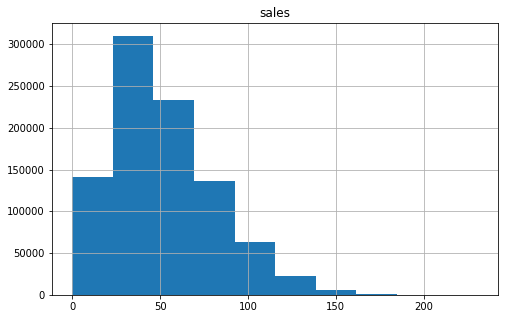

In [20]:
# original
df2.hist('sales',figsize=(8,5))

In [21]:
df2['sales']= np.log1p(df2["sales"].values)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7c7516c2d0>]],
      dtype=object)

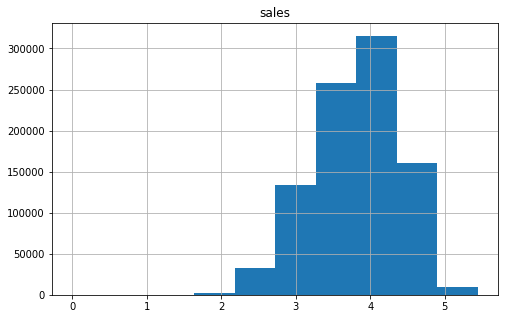

In [22]:
# transformed
df2.hist('sales',figsize=(8,5))

### Split into train val test

* train: 2013 to 2016 (4 years) - 80%
* val: 2017 (1 year) - 20%
* test: 2018 onwards

In [23]:
df_model = df2.copy()

In [24]:
df_model = df_model.sort_values("date").reset_index(drop = True)

In [25]:
train = df_model.loc[(df_model["date"] < "2017-01-01"), :]

val = df_model.loc[(df_model["date"] >= "2017-01-01") & (df_model["date"] < "2017-04-01"), :]

In [26]:
train.head()

,date,sales,id,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,...,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,quarter_1,quarter_2,quarter_3,quarter_4
0,2013-01-01,2.639057,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,0,0,0,0,0,1,0,0,0
1,2013-01-01,2.833213,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,0,0,0,0,0,1,0,0,0
2,2013-01-01,3.044522,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,0,0,0,0,0,1,0,0,0
3,2013-01-01,3.555348,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,0,0,0,0,0,1,0,0,0
4,2013-01-01,2.995732,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,0,0,0,0,0,1,0,0,0


In [27]:
val.head()

,date,sales,id,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,...,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,quarter_1,quarter_2,quarter_3,quarter_4
730500,2017-01-01,3.663562,NaN,49.0,59.0,43.0,50.0,45.0,62.0,78.0,...,0,0,0,0,0,1,1,0,0,0
730501,2017-01-01,4.682131,NaN,131.0,167.0,142.0,145.0,159.0,171.0,189.0,...,0,0,0,0,0,1,1,0,0,0
730502,2017-01-01,4.077537,NaN,69.0,84.0,92.0,86.0,109.0,90.0,110.0,...,0,0,0,0,0,1,1,0,0,0
730503,2017-01-01,3.295837,NaN,40.0,34.0,33.0,33.0,34.0,44.0,39.0,...,0,0,0,0,0,1,1,0,0,0
730504,2017-01-01,3.367296,NaN,38.0,37.0,55.0,42.0,41.0,52.0,43.0,...,0,0,0,0,0,1,1,0,0,0


In [28]:
cols = [col for col in train.columns if col not in ['date', 'id', "sales"]]

In [29]:
X_train = train[cols]
Y_train = train['sales']

X_train.shape, Y_train.shape

((730500, 193), (730500,))

In [30]:
X_val = val[cols]
Y_val = val['sales']

X_val.shape, Y_val.shape

((45000, 193), (45000,))

## LighGBM regressor

In [31]:
model = lgb.LGBMRegressor()

In [32]:
# get baseline model parameters
model.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [33]:
t0 = time.time()

first_model = model.fit(X_train, Y_train, 
                       eval_set=[(X_val, Y_val)],
                       early_stopping_rounds=10)

t1 = time.time()
train_time = t1 - t0

[1]	valid_0's l2: 0.264106
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 0.225372
[3]	valid_0's l2: 0.193591
[4]	valid_0's l2: 0.167289
[5]	valid_0's l2: 0.145328
[6]	valid_0's l2: 0.126732
[7]	valid_0's l2: 0.111553
[8]	valid_0's l2: 0.0990251
[9]	valid_0's l2: 0.0886478
[10]	valid_0's l2: 0.0799642
[11]	valid_0's l2: 0.0727189
[12]	valid_0's l2: 0.0669187
[13]	valid_0's l2: 0.0621213
[14]	valid_0's l2: 0.05803
[15]	valid_0's l2: 0.0546821
[16]	valid_0's l2: 0.0517506
[17]	valid_0's l2: 0.0491507
[18]	valid_0's l2: 0.0471477
[19]	valid_0's l2: 0.045287
[20]	valid_0's l2: 0.0438528
[21]	valid_0's l2: 0.0424927
[22]	valid_0's l2: 0.0413662
[23]	valid_0's l2: 0.0403311
[24]	valid_0's l2: 0.0395144
[25]	valid_0's l2: 0.0387095
[26]	valid_0's l2: 0.0380966
[27]	valid_0's l2: 0.037583
[28]	valid_0's l2: 0.0370691
[29]	valid_0's l2: 0.0366604
[30]	valid_0's l2: 0.0362581
[31]	valid_0's l2: 0.0359317
[32]	valid_0's l2: 0.0356741
[33]	valid_0's l2: 0.0354088
[

In [34]:
# pickling the model
pickle.dump(first_model, open('lightgbm-base_regressor.sav', 'wb'))

## Model evaluation

In [35]:
# define smape metric
def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds-target)
    denom = np.abs(preds)+np.abs(target)
    smape_val = (200*np.sum(num/denom))/n

    return smape_val

def xgb_smape(y_pred, y_true):
    smape_val = smape(np.expm1(y_pred), np.expm1(y_true))
    
    return 'SMAPE', smape_val, False

In [36]:
print("SMAPE:", smape(np.expm1(first_model.predict(X_val)), np.expm1(Y_val)))
print("\nMean squared error (MSE):", mean_squared_error(Y_val, first_model.predict(X_val)))
print("\nR2 score:", r2_score(Y_val, first_model.predict(X_val)))
print("\nTraining time: %fs" % (train_time))

SMAPE: 13.905460913601182

Mean squared error (MSE): 0.0316476289720676

R2 score: 0.8956434010512161

Training time: 25.141371s


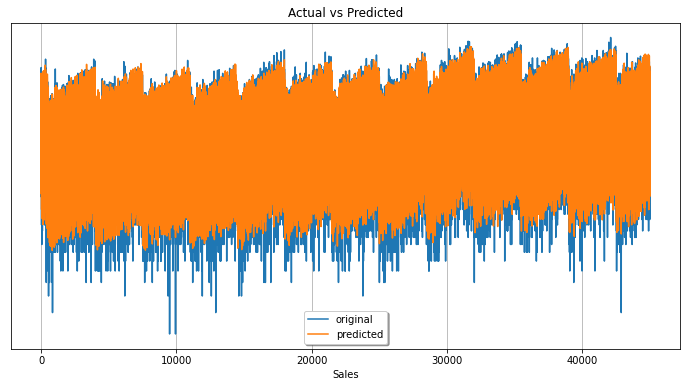

<Figure size 432x288 with 0 Axes>

In [37]:
# visualize results
x_ax = range(len(Y_val))
plt.figure(figsize=(12, 6))
ax = plt.gca()
ax.get_yaxis().set_visible(False)

plt.plot(x_ax, Y_val, label="original")
plt.plot(x_ax, first_model.predict(X_val), label="predicted")
plt.xlabel('Sales')

plt.title("Actual vs Predicted")
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()

plt.savefig('LightGBM Base Actual vs Predicted.png')

## Feature importance

In [38]:
boost = first_model.booster_
feature_importance = pd.DataFrame(data   = first_model.feature_importances_,
                 index  = boost.feature_name(),
                 columns = ['importance'])

# top 20
feature_importance.sort_values('importance', ascending=False).head(20)

,importance
sales_lag_364,389
sales_roll_mean_546,385
month_12,127
sales_ewm_alpha_05_lag_365,122
day_of_week_0,119
sales_ewm_alpha_05_lag_728,81
quarter_1,77
day_of_week_6,69
month_7,67
month_1,62


<Figure size 2160x720 with 0 Axes>

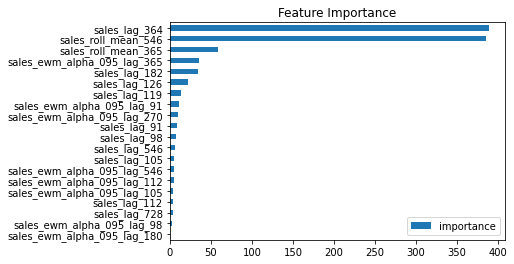

<Figure size 432x288 with 0 Axes>

In [39]:
plt.figure(figsize=(30, 10))
feature_importance.head(20).sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.legend(loc='lower right')
plt.show()

plt.savefig('LightGBM Base Top 20 Features.png')

In [40]:
feature_importance.to_csv('lightgbm_base-feature_importance.csv', index=False)

## Predict on test

In [41]:
df_final_model = df2.copy()
test = df_final_model.loc[df_final_model.sales.isna()]
X_test = test[cols]

In [42]:
X_test.head()

,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,...,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,quarter_1,quarter_2,quarter_3,quarter_4
0,12.0,14.0,22.0,16.0,12.0,15.0,18.0,15.0,18.0,12.0,...,0,0,0,0,0,0,1,0,0,0
1,18.0,18.0,21.0,20.0,26.0,21.0,23.0,10.0,31.0,12.0,...,1,0,0,0,0,0,1,0,0,0
2,15.0,27.0,20.0,13.0,24.0,22.0,23.0,16.0,22.0,16.0,...,0,1,0,0,0,0,1,0,0,0
3,20.0,23.0,20.0,26.0,29.0,26.0,31.0,14.0,33.0,12.0,...,0,0,1,0,0,0,1,0,0,0
4,19.0,28.0,28.0,28.0,28.0,38.0,32.0,24.0,34.0,12.0,...,0,0,0,1,0,0,1,0,0,0


In [43]:
test_preds = first_model.predict(X_test)

test_preds

array([2.60331397, 2.75319463, 2.75310781, ..., 4.39489935, 4.39575122,
       4.51206062])

In [44]:
submission_df = test.loc[:, ['id', 'sales']]
submission_df['sales'] = np.expm1(test_preds)
submission_df['id'] = submission_df.id.astype(int)
submission_df['sales'] = submission_df.sales.astype(int)

submission_df.head()

,id,sales
0,0,12
1,1,14
2,2,14
3,3,15
4,4,17


In [45]:
submission_df.to_csv('lightgbm-base_submission.csv', index=False)